In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn import linear_model

# Pandas is used for data structure (series and dataframe) that will be used to store the data
# Numpy is used for scientific calculation 
# Matplotlib and seaborn is used to provide visualisation (bar plot, scatter plote, box plot, heat map)
# Seaborn also used for choosing color palette
# sklearn library is used to perform k means clustering, decision tree, linear regression, splliting training
# and test data, as well as measure accuracy

C:\Users\keyst\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Set grid color for seaborn
# sns.set(style="whitegrid")

## Preprocessing (Cleaning and Integration)

In [3]:
# Open CSV files that are needed
offence_data = pd.read_csv("lga-offence-raw.csv", encoding = "ISO-8859-1")
community_data = pd.read_csv("community-data-raw.csv", encoding = "ISO-8859-1")

# Edit column name for consistency and readability purposes, inner join
newColumns = ["vic_erp", "lga_name", "lga_code", "c_total", "e_total", "d_total", "b_total", "a_total", 
              "ref_period", "offence_total", "lga_erp", "f_total"]
offence_data.columns = newColumns
offence_data.set_index("lga_code", inplace = True)

newColumns = ["volunteer_rating_percentage", "id", "lga_name", "lga_code", "good_community_support_group_percentage",
              "pleasant_community_environment_percentage", "get_help_by_neighbour_percentage", "active_community_percentage",
              "attend_community_event_percentage", "valued_by_society_percentage"]
community_data.columns = newColumns
community_data.set_index("lga_code", inplace = True)
del community_data["id"]

# Create offence data / 100000 population so that analysis is unbiased by population growth
# Will be used when computing correlation
normalise_rate = 100000
normalised_offence_data = pd.DataFrame()
offence_code = ["a_total", "b_total", "c_total", "d_total", "e_total", "f_total", "offence_total"]
for column in offence_code:
    normalised_offence_data[column] = offence_data[column] / offence_data["lga_erp"] * normalise_rate 
normalised_offence_data["lga_name"] = offence_data["lga_name"]
normalised_offence_data["ref_period"] = offence_data["ref_period"]

# Save to csv files the file that already finalise (column name)
normalised_offence_data.to_csv("normalised-offence-data.csv", encoding = "ISO-8859-1")
community_data.to_csv("community-data-cleaned.csv", encoding = "ISO-8859-1")
# Still need a copy of original offence data for background research,
# display increasing rate of crime rate
del offence_data["vic_erp"]
offence_data.to_csv("preprocess-offence-data.csv", encoding = "ISO-8859-1")

# Calculate average of offence rate for the past 5 years (will be used in correlation computation)
grouped = normalised_offence_data.groupby("ref_period")
df_collection = []
for k, group in grouped:
    df_collection.append(group)

# Taking sum process for every year (will be use for averaging)
average_df = df_collection[0]
newColumns = ["c_total", "e_total", "d_total", "b_total", "a_total", "offence_total", "f_total"]
for i in range(1, len(df_collection)):
    for column in newColumns:
        average_df[column] = average_df[column] + df_collection[i][column]
        
# Divide by number of year to find average
for column in newColumns:
    average_df[column] = average_df[column] / len(df_collection)

# delete ref_period as it already average
del average_df["ref_period"]

# Merging Process based on lga_code
merge_df = average_df.merge(community_data, left_index = True, right_index = True)
del merge_df["lga_name_y"]
merge_df.rename(columns = {"lga_name_x": "lga_name"}, inplace = True)

# write to csv for reusability
merge_df.to_csv("merged-offence-community.csv", sep = ",")

In [12]:
# Outlier detection algorithm used for preprocessing step
def outlier_detection(dataframe, column_name):
    q1 = np.percentile(dataframe[column_name], 25)
    q3 = np.percentile(dataframe[column_name], 75)
    iqr = q3 - q1
    
    inner_fence_upper = q3 + 1.5 * iqr
    inner_fence_lower = q1 - 1.5 * iqr
    
    outer_fence_upper = inner_fence_upper + 1.5 * iqr
    outer_fence_lower = inner_fence_lower - 1.5 * iqr
    
    suspected_outliers = []
    outliers = []
    for k, v in dataframe.iterrows():
        if (v[column_name] > inner_fence_upper or v[column_name] < inner_fence_lower):
            suspected_outliers.append(v["lga_name"])
        if (v[column_name] > outer_fence_upper or v[column_name] < outer_fence_lower):
            outliers.append(v["lga_name"])
            outliers.append(v["offence_total"])
    
    return {"suspected_outliers": set(suspected_outliers), "outliers": set(outliers)}

print("Suspected Outliers:")
print(outlier_detection(average_df, "offence_total")["suspected_outliers"])
print("Outliers: ")
print(outlier_detection(average_df, "offence_total")["outliers"])

# Suspected outliers is too low for analysis
sns.boxplot(average_df["offence_total"], orient="v", width=0.3, color="darkred", whis=3)
plt.ylabel("Offence Total")
plt.xlabel("LGA")
# plt.show()

sns.boxplot(community_data["volunteer_rating_percentage"], orient="v", width=0.3, whis=3)
plt.ylabel("Volunteer Rating Percentage")
plt.xlabel("LGA")
# plt.show()


Suspected Outliers:
{'Latrobe (C)', 'Melbourne (C)'}
Outliers: 
{'Melbourne (C)', 27799.16960952365}


Text(0.5,0,'LGA')

## Result

#### Information About Crime Rates in Victoria 

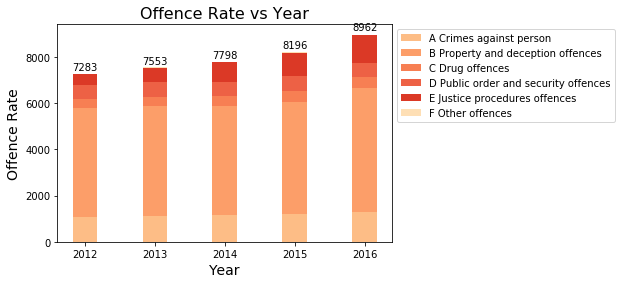

In [5]:
offence_data = pd.read_csv("preprocess-offence-data.csv", encoding = "ISO-8859-1")

# Label top of bar point
def label(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., 1.02*height,
               '%d' % int(height), ha = "center", fontsize = 10)

# Get the total number of offence each year
grouped = offence_data.groupby("ref_period")
offence_code = ["a_total", "b_total", "c_total", "d_total", "e_total", "f_total", "offence_total"]
offence_year_data = []
normalise_rate = 100000
# Iterate every year to get the total value of crime rate in that year
for k, group in grouped:
    # Calculate erp of victoria in a particular year
    vic_erp = group["lga_erp"].sum()
    
    # Store total number of crime (a-f, total) per year that has been normalised
    crime_year_list = []
    for column in offence_code:
        crime_year_list.append(group[column].sum() / vic_erp * normalise_rate)    

    offence_year_data.append(crime_year_list)

y_data = [[],[],[],[],[],[],[]] # [[a], [b], [c], [d], [e], [f], [total]]
# Iterate offence_year_data and group based on category for every year
# i.e [[a_2012,a_2013,...],...]
for i in range(len(offence_year_data)):
    for j in range(len(offence_year_data[i])):
        y_data[j].append(offence_year_data[i][j])

# PLOT to provide background information regarding increasing offence rate
# Show offence increasing rate which thus a major problem in victoria
year = [2012, 2013, 2014, 2015, 2016] # x data
figure = plt.figure()
ax = figure.add_subplot(111)
width = 0.35

# Create a stacked bar plot
p_tot = ax.bar(year, y_data[6], width) # will be overwritten, just for labelling purposes
p_a = ax.bar(year, y_data[0], width, color=sns.color_palette("OrRd", 10)[3])
p_b = ax.bar(year, y_data[1], width, color=sns.color_palette("OrRd", 10)[4], bottom=y_data[0])
p_c = ax.bar(year, y_data[2], width, color=sns.color_palette("OrRd", 10)[5], bottom=np.add(y_data[0], y_data[1]))
p_d = ax.bar(year, y_data[3], width, color=sns.color_palette("OrRd", 10)[6], bottom=np.add(np.add(y_data[0],y_data[1]),y_data[2]))
p_e = ax.bar(year, y_data[4], width, color=sns.color_palette("OrRd", 10)[7], bottom=np.add(np.add(np.add(y_data[0],y_data[1]),y_data[2]), y_data[3]))
p_f = ax.bar(year, y_data[5], width, color=sns.color_palette("OrRd", 10)[1], bottom=np.add(np.add(np.add(np.add(y_data[0],y_data[1]),y_data[2]), y_data[3]), y_data[4]))

# Settings
ax.xaxis.grid(False)
plt.title("Offence Rate vs Year", fontsize = 16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Offence Rate", fontsize=14)
plt.legend((p_a[0], p_b[0], p_c[0], p_d[0], p_e[0], p_f[0]), ("A Crimes against person", 
                                                              "B Property and deception offences", 
                                                              "C Drug offences", 
                                                              "D Public order and security offences",  
                                                              "E Justice procedures offences", "F Other offences"), bbox_to_anchor=(1,1))
label(p_tot)
plt.show()

#### Volunteering Participation Information

In [6]:
# Provide background information regarding distribution percentage of volunteer activity
figure2 = plt.figure(figsize = (13, 7))
ax = figure2.add_subplot(111)
bars2 = ax.bar(range(len(community_data["lga_name"])), community_data["volunteer_rating_percentage"], color = sns.color_palette("RdBu", n_colors=7)[6])
ax.xaxis.grid(False)

plt.title("Participation in Volunteering Activities vs LGA Name", fontsize = 22)
plt.xticks(range(len(community_data["lga_name"])), community_data["lga_name"], rotation = "vertical", fontsize = 8)
plt.xlabel("LGA Name", fontsize = 14)
plt.ylabel("Percentage of people participating in voluteering activities (%)", fontsize = 14)
plt.xlim(-1, 79)
label(bars2)

# plt.show()

#### Correlation of Crime Rate and Good Community and Support

In [8]:
# Visualizing Using Scatter Plot

merge_df = pd.read_csv("merged-offence-community.csv", encoding = "ISO-8859-1")
x = merge_df["volunteer_rating_percentage"]
y = merge_df["offence_total"]

# Create scatter plot
plt.scatter(x, y, color="orange")
plt.title("Offence Rate vs Participation in Voluteering Activities", fontsize = 16)
plt.xlabel("Percentage of people participating in volunteering activities (%)")
plt.ylabel("Offence Rate")

# Create line of best fit
a, b = np.polyfit(x, y, 1)
plt.plot(x, a*x + b, '-')

In [9]:
# Using Pearson Correlation 
# Calculate pearson correlation of 2 variables
def pearson_correlation(series_x, series_y, average_x, average_y):
    
    covariance = 0
    var_x = 0
    var_y = 0
    # Calculate numerator (covariance), denominator (standard deviation x, standard deviation y)
    # Note that the average has already been canceled beforehand
    for i in range(len(series_x)):
        covariance = covariance + ((series_x[i] - average_x) * (series_y[i] - average_y))
        var_x = var_x + (series_x[i] - average_x)**2
        var_y = var_y + (series_y[i] - average_y)**2
    
    # Change variance to standard deviation
    sd_x = var_x**0.5
    sd_y = var_y**0.5
    
    # Using the formula of pearson correlation:
    correlation = covariance / (sd_x * sd_y)
    return correlation

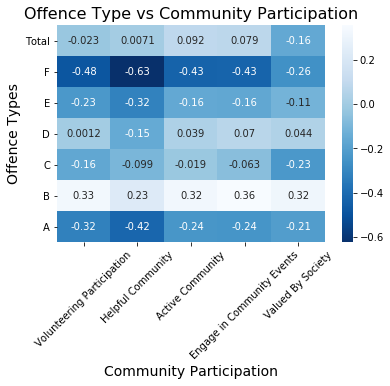

In [10]:
# Create a heat map using seaborn
# Create a dataframe that will be used
# x axis: volunteering participation, helpful community, active community, 
# engage in community events, valued by society
# y axis: type a, type b, type c, type d, type e, type f, total crime
correlation_data = pd.DataFrame()
y_axis = ["a_total", "b_total", "c_total", "d_total", "e_total", "f_total", "offence_total"]
x_axis = ["volunteer_rating_percentage", "get_help_by_neighbour_percentage", "active_community_percentage"
         , "attend_community_event_percentage", "valued_by_society_percentage"]

# Get a series consisting of correlation between a particular column with y_axis
for x in x_axis:
    correlation = []
    average_x = merge_df[x].mean()
    for y in y_axis:
        average_y = merge_df[y].mean()
        # Find correlation between each column and each type of crime
        correlation.append(pearson_correlation(merge_df[y], merge_df[x], average_y, average_x))
    correlation_data[x] = correlation

# Set the index to y_axis that will be display as y axis on the heat map
correlation_data["offence_type"] = y_axis
correlation_data.set_index("offence_type", inplace=True)

# Create a heatmap based on the result
sns.heatmap(correlation_data, cmap="Blues_r", annot=True)
plt.title("Offence Type vs Community Participation", fontsize=16)
plt.xlabel("Community Participation", fontsize=14)
plt.ylabel("Offence Types", fontsize=14)
plt.xticks(np.arange(5) + 0.5, ["Volunteering Participation", "Helpful Community", "Active Community", "Engage in Community Events", "Valued By Society"]
    , rotation=45)
plt.yticks(np.arange(7) + 0.5, ["Total", "F", "E", "D", "C", "B", "A"], rotation="horizontal")

plt.show()
